<a href="https://colab.research.google.com/github/MarioCapodanno/FRO_Project_2024/blob/main/FRO_Project_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#FRO Project 2023/2024
* Solution by Capodanno Mario, Maria Cristina De Terry Paredes, Andrea Tosi.
* Problem 1 result: [Total cost of installation: 12348.0]
* Problem 2 result: [Total cost of installation: 12924.0]

# Optimal charging station location on a cycleway


Consider a long linear cycle path  as Vento (VENezia-TOrino), or the Danube cycle path. The cycle path usually runs along the banks of a river with scarse tourist interest. However, from the main course of the cycle path it is possible to reach places of tourist interest by making small detours.  

The rapid growth of e-bike ridership is proposing the problem of deploying a suitable charging infrastructure. The charging stations should be placed in strategic positions so as to guarantee a coverage of the whole cycle path. However, since the charging operations require a non negligible time, the charging station should be positioned in places where alternative activities could be carried out, as restaurants, museums, swimming pool, or other amenities. These places, called **Points of Interest (POI)**  are not on the main trajectory of the cyclepath, but the bikers must deviate to reach them.

We assume that the bikers enter the cyclepath where it begins and finish the trip ath the end of the cyclepath. When they enter the battery is fully charged. Moreover, the bikers will make all possible deviations in order to visit all the POIs.







## Formulation

To support the formulation we make use of a graph with $2n+2$ nodes.
Nodes $s$ and $t$ represent the extremes of the cyclepath.

Nodes

*   $L = \{1,\ldots,n\}$:  locations along the cyclepath from which bikers deviate


*   $H = \{1',\ldots, n'\}$:  POIs that may host a charging station.

*   $\{s,t\}$: extremes of the cyclepath.

Arcs

*  $\{(i,i+1), (i+1, i) 1,\ldots,n \}$: arcs of the cyclepath in the two directions

*  $\{(i,i'), (i',i), i\in L, i'\in H\}$: arcs representing the deviations from the cyclepath

### Example of the graph
![picture](https://drive.google.com/file/d/1A4dSP-4K1E3jwaab4A8JT21TKD7FINaK/view?usp=drive_link)

### Parameters

*   $d_{i,i+1}, d_{i+1,i}, i=1,\ldots,n-1$: energy consumption between consecutive nodes,
*   $d_{i,i'}, d_{i',i}, i \in L, i'\in H$: energy consumption for the deviations
*   $c_i'$: cost of installing a charging station in site $i' \in H$
*   $\Delta$: maximum energy consumption between consecutive charging stations

We assume that $d_{s,1} d_{1,s} = d_{n,t} = d_{t,n} = 0$.
Note that the energy consumption on each arc can be different in the two directions, depending on the orography.








## Problem 1

Consider a biker that traverses the cyclepath from $s$ to $t$, determine in which nodes of $H$ to install the charging stations so that the maximum energy consumption between two consecutive charging stations is no more than $\Delta$ and minimize the overall cost.



## Problem 2

Consider a biker that traverses the cyclepath from $t$ to $s$, determine in which nodes of $H$ to install the charging stations so that the maximum energy consumption between two consecutive charging stations is no more than $\Delta$ and minimize the overall cost.

### Comments
Do you obtain the same solution? Why?

### Recommendation
The problems can be solved by a simple formulation. The solution of complex problems as the TSP is not necessary.
Do not use external libraries apart from those presented in class.



In [ ]:
#import libraries

!pip install mip
!pip install --upgrade cffi==1.15.0
!pip install pydot
import importlib
import cffi
importlib.reload(cffi)
import numpy as np
import math
import networkx as nx

In [ ]:
# ignore warning from library networx
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Helper functions

In [ ]:
# Drawn the graph using the library networkx (used in lab2)
def draw_graph(graph,
               highlighted_nodes=None,
               selected_arcs=None,
               title="Graph",
               layout='spring',
               show_weight=True,
               node_labels = None):

    # Draw nodes using the label given if passed as parameter
    if node_labels:
      nx.draw(G, pos = nx.nx_pydot.graphviz_layout(G), node_size=400, node_color='lightblue', linewidths=0.25, font_size=8, font_weight='bold', with_labels=True, labels=node_labels)
    else:
      nx.draw(G, pos = nx.nx_pydot.graphviz_layout(G), node_size=400, node_color='lightblue', linewidths=0.25, font_size=8, font_weight='bold', with_labels=True)

    # Draw edge labels (weights)
    if show_weight:
      edge_labels = nx.get_edge_attributes(graph, 'weight')
      nx.draw_networkx_edge_labels(graph, pos = nx.nx_pydot.graphviz_layout(G), edge_labels=edge_labels)

    # Highlight specific nodes if provided
    if highlighted_nodes:
        nx.draw_networkx_nodes(graph, pos = nx.nx_pydot.graphviz_layout(G), nodelist=highlighted_nodes, node_color='orange')

    # Highlight specific arcs if provided
    if selected_arcs:
        nx.draw_networkx_edges(graph, pos = nx.nx_pydot.graphviz_layout(G), edgelist=selected_arcs, edge_color='green', width=3)


    plt.title(title)
    plt.show()
#=================================================================================================================================================================================================
# FUNCTIONS HELPFUL FOR THE COMMENT SECTION

# Define a function to calculate the total installation cost for a permutation
def total_installation_cost(perm):
    return sum(inst_cost[i] for i in range(n1) if perm[i] == 1)

# Define a function to check if a permutation is valid
def is_valid_permutation(perm):
    # Take the sites number where the charging point is istalled
    active_charging_points = [i for i in range(n1) if perm[i] == 1]

    # Take out immediatly the impossibile valid permutation
    if len(active_charging_points) <= 5:
            return False

    # Check if the route from s to the first POI with a charging station istalled is valid (total consume is less than delta=50).
    if ( sum(consumption[j] for j in range(0, active_charging_points[0] )) +
         sum(consumption_deviation[h] for h in range(0, active_charging_points[0]))  +
         sum(consumption_deviation[k] for k in range(1, active_charging_points[0]+ 1)))   > 50:
            return False

    # Check each route between two POIs with charging station istalled if the path is valid.
    for i in active_charging_points:
      current_idx = active_charging_points.index(i)

      # if it's not the last charging point, check if between two consecutive charging point if  the total consume is less than 50.
      if current_idx != ( len(active_charging_points) -1 ):
        next_charg_point = active_charging_points[active_charging_points.index(i) + 1]
        if (sum(consumption[j] for j in range(i, next_charg_point )) +
            sum(consumption_deviation[h] for h in range(i, next_charg_point)) +
            sum(consumption_deviation[k] for k in range(i+1, next_charg_point + 1))) > 50:
            return False
      # if current_idx refer to the last charging point check if the path from site i' of the current POIS can reach the last site.
      else:
        if (sum(consumption[j] for j in range(i, n1-1 )) +
            sum(consumption_deviation[h] for h in range(i, n1)) +
            sum(consumption_deviation[k] for k in range(i+1, n1))) > 50:
            return False
    return True

## Solution Problem 1

In [ ]:
#raw data PROBLEM 1

n = 15  # number of nodes on the main course
n1 = 15 # number of touristic sites
delta = 50  # max distance before recharge
s = 0   # starting point
t = n  # destination
consumption = [20, 32, 11, 37, 7, 14, 22, 5, 35, 17, 23, 3, 26, 24] # consumption (in Wh) between two consecutive location along the main course
consumption_deviation = [1.1, 0.7, 0.4, 0.9, 2.1, 1.8, 0.5, 0.4, 1.6, 2.5, 1.4, 0.8, 2.0, 1.3, 0.1] # consumption (in Wh) of the deviation
inst_cost = [1492, 1789, 1914, 1861, 1348, 1769, 1123, 1432, 1564, 1818, 1901, 1265, 1642, 1712, 1756] #cost (in €) of installation of a charging point related to the node

In [ ]:
# Adding main path nodes -> new nodes: start(s=0) and destination(t=16).
N=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

# Consumption between two consecutive location along the main course [Wh]
consumption.insert(0,0) # Consume at the node s(=0) is 0
consumption.append(0) # Consume at the node t(=16) is 0
# Consumption of the deviation from the site i to i' (the same from i' -> i) [Wh]
consumption_deviation.insert(0,0)
consumption_deviation.append(0)
# Cost of installation of a charging point related to the node [€]
inst_cost.insert(0,0)
inst_cost.append(0)

### Building the graph

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import mip

# Create the starting graph
G = nx.DiGraph()

# Adding the N nodes to the graph G
G.add_nodes_from(N)

# Adding arcs, each arcs (i,j) has has weight the installation cost of the chargin station on j':
#
#                                          (consume from the site i to the site j)                                                              (consume of entering POIs from i to j)
#                                                            |                                                                                                     |
#                                           ____________________________________                                                          ___________________________________________________
#                                          /                                    \                                                        /                                                   \
A=[(i,j) for i in N for j in N if i<j and (sum(consumption[h] for h in range(i,j)) + sum(consumption_deviation[h] for h in range(i,j)) + sum(consumption_deviation[h] for h in range(i+1, j+1))  )<= delta ]
#         \_________________________/                                                \______________________________________________/
#                     |                                                                                       |
#        i<j: implies the direction require by PROBLEM 1 (s--> t)                             (consume of exiting POIs from i to j-1)
#

# Adding edges to the graph G
G.add_edges_from(A)

# Dictionaries of the cost of the edge(i,j)
cost_edges = { (i,j): inst_cost[j] for (i,j) in A}

# Show the valid arcs and their weight
for (i, j), cost in cost_edges.items():
    print('The arc: ' + str((i,j)) + ' has weight ' + str(cost_edges.get((i,j))))
    G.add_edge(i, j, weight=cost)


The arc: (0, 1) has weight 1492
The arc: (0, 2) has weight 1789
The arc: (1, 2) has weight 1789
The arc: (2, 3) has weight 1914
The arc: (2, 4) has weight 1861
The arc: (3, 4) has weight 1861
The arc: (4, 5) has weight 1348
The arc: (5, 6) has weight 1769
The arc: (5, 7) has weight 1123
The arc: (6, 7) has weight 1123
The arc: (6, 8) has weight 1432
The arc: (6, 9) has weight 1564
The arc: (7, 8) has weight 1432
The arc: (7, 9) has weight 1564
The arc: (8, 9) has weight 1564
The arc: (8, 10) has weight 1818
The arc: (9, 10) has weight 1818
The arc: (10, 11) has weight 1901
The arc: (10, 12) has weight 1265
The arc: (11, 12) has weight 1265
The arc: (11, 13) has weight 1642
The arc: (12, 13) has weight 1642
The arc: (12, 14) has weight 1712
The arc: (13, 14) has weight 1712
The arc: (14, 15) has weight 1756
The arc: (14, 16) has weight 0
The arc: (15, 16) has weight 0


### Draw the initial graph

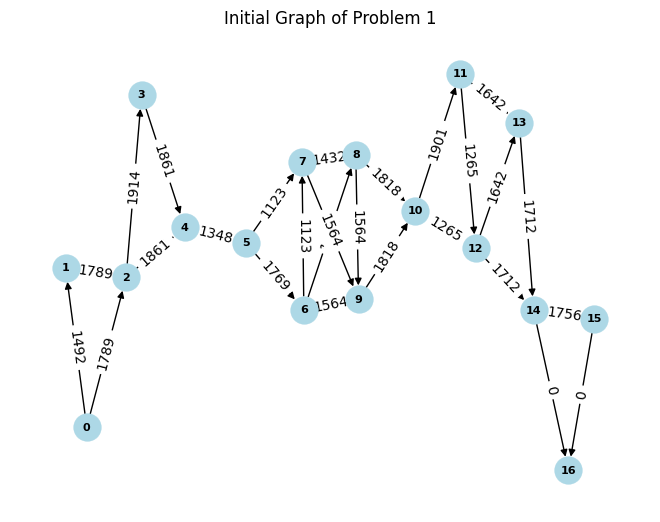

In [ ]:
draw_graph(G, title="Initial Graph of Problem 1", layout='spring')

### Define the model and compute the optimal solution

In [ ]:
import mip
# Create MIP model
m= mip.Model()

# Define the variable:
# f(i,j): equal to 1 if the site j' has a charging station installed and the optimal route contains the arc (i,j)
f= {(i,j):m.add_var(var_type=mip.BINARY) for (i, j) in A}

# Define the contraints
b={i: 0 for i in N}
b[0]=1
b[16]= -1

# Write flow conservation constraint
for i in N:
  m.add_constr(mip.xsum(f[i,j] for j in N if (i,j) in A) - mip.xsum(f[j,i] for j in N if (j,i) in A)==b[i])

# Minimize cost of installation
m.objective= mip.minimize(mip.xsum(inst_cost[j]*f[i,j] for (i,j) in A))

m.optimize()


<OptimizationStatus.OPTIMAL: 0>

In [ ]:
# Output the result
print("Total cost of installation:", m.objective_value)

Total cost of installation: 12348.0


In [ ]:
# Arcs of the mininum cost path
for (i,j) in A:
  if f[i,j].x >= 0.5:
    print(i,"--->", j)

0 ---> 2
2 ---> 4
4 ---> 5
5 ---> 7
7 ---> 8
8 ---> 10
10 ---> 12
12 ---> 14
14 ---> 16


### Draw the final graph with the selected POIs

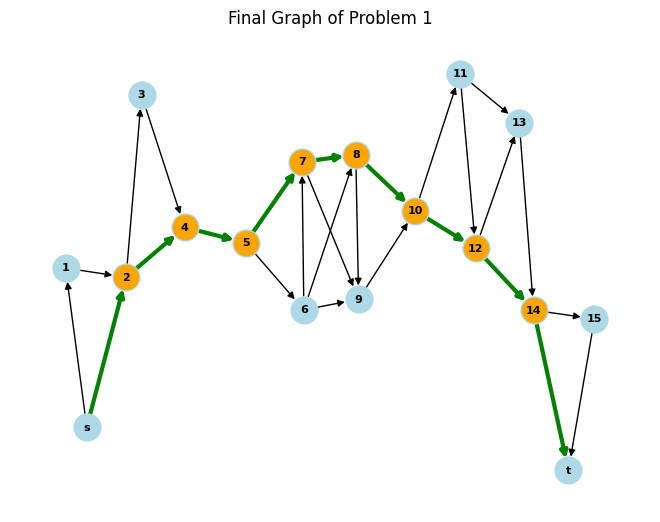

In [ ]:
# Pick the POIs j with a charging station installed if F[i,j] = 1
selected_pois = [j for (i,j) in A if f[i,j].x > 0.001 and j!=16]
selected_arcs = [(i,j) for (i,j) in A if f[i,j].x > 0.001]

node_labels = {i : i for i in range(1, 16)}
node_labels[0] = 's'
node_labels[16] = 't'

draw_graph(G, selected_pois, selected_arcs, title="Final Graph of Problem 1", layout='spring', show_weight=False, node_labels=node_labels)

The following graph is equal to the last graph:

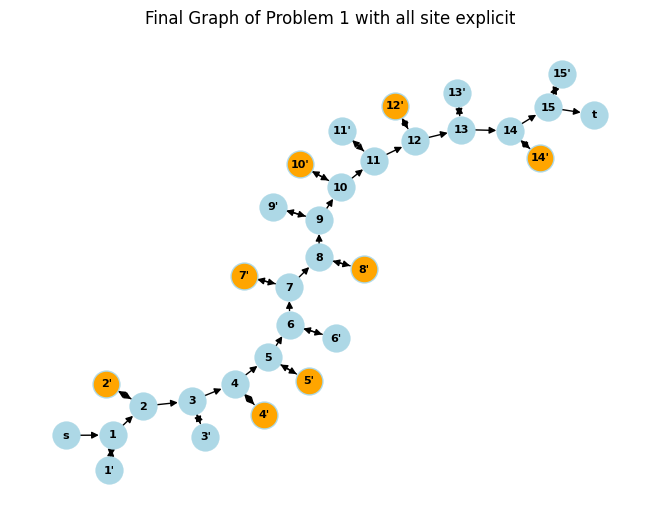

In [ ]:
# Define the graph
G = nx.DiGraph()

# Define nodes
nodes = ['s', 1, "1'", 2, "2'", 3, "3'", 4, "4'", 5, "5'", 6, "6'", 7, "7'", 8, "8'", 9, "9'", 10, "10'", 11, "11'", 12, "12'", 13, "13'", 14, "14'", 15, "15'", 't']

# Define edges
edges = [
    ('s', 1), (1, "1'"), ("1'", 1), (1, 2), (2, "2'"), ("2'", 2), (2, 3), (3, "3'"), ("3'", 3), (3, 4), (4, "4'"),
    ("4'", 4), (4, 5), (5, "5'"), ("5'", 5), (5, 6), (6, "6'"), ("6'", 6), (6, 7), (7, "7'"), ("7'", 7), (7, 8), (8, "8'"),
    ("8'", 8), (8, 9), (9, "9'"), ("9'", 9), (9, 10), (10, "10'"), ("10'", 10), (10, 11), (11, "11'"), ("11'", 11),
    (11, 12), (12, "12'"), ("12'", 12), (12, 13), (13, "13'"), ("13'", 13), (13, 14), (14, "14'"), ("14'", 14),
    (14, 15), (15, "15'"), ("15'", 15), (15, 't')
]

# Add nodes to the graph
G.add_nodes_from(nodes)

# Add edges to the graph
G.add_edges_from(edges)

selected_poi = [node for node in nodes if isinstance(node, str) and node.endswith("'") and (int(node.replace("'","")) in selected_pois)]
# Draw the graph using the custom function
draw_graph(G, selected_poi, title="Final Graph of Problem 1 with all site explicited", layout='spring', show_weight=False,node_labels={n: n for n in G.nodes()})

***Useful for comment section:***

In [ ]:
# The following lines are used to support the comment section
# Check arc (13, t) for the problem 1:
print('Check feasibility of arc (13, t) in problem 1:')
print('* Consumption from the node 13 to t is equal to: ' + str(sum(consumption[h] for h in range(13,16))))
print('* Consumption deviation (entering the POI) from the node 13 to t is equal to: ' + str(sum(consumption_deviation[h] for h in range(13,16))))
print('* Consumption deviation (exiting the POI) from the node 13 to t is equal to: ' + str(sum(consumption_deviation[h] for h in range(13+1,16+1))))
print(' ==============> 50 + 3.4 + 1.4 = 54.8 < Δ : FEASIBLE')
print('-----------------------------------------')
# Check arc (12, 13) for the problem 1:
print('Check feasibility of arc (12,13) in problem 1')
print('* Consumption from the node 13 to t is equal to: ' + str(sum(consumption[h] for h in range(12,13))))
print('* Consumption deviation (entering the POI) from the node 12 to 13 is equal to: ' + str(sum(consumption_deviation[h] for h in range(12,13))))
print('* Consumption deviation (exiting the POI) from the node 12 to 13 is equal to: ' + str(sum(consumption_deviation[h] for h in range(12+1,13+1))))
print(' ==============> 3 + 0.8 + 2 = 5.8 < Δ : FEASIBLE')

Check feasibility of arc (13, t) in problem 1:
* Consumption from the node 13 to t is equal to: 50
* Consumption deviation (entering the POI) from the node 13 to t is equal to: 3.4
* Consumption deviation (exiting the POI) from the node 13 to t is equal to: 1.4000000000000001
 ==============> 50 + 3.4 + 1.4 = 54.8 < Δ : FEASIBLE
-----------------------------------------
Check feasibility of arc (12,13) in problem 1
* Consumption from the node 13 to t is equal to: 3
* Consumption deviation (entering the POI) from the node 12 to 13 is equal to: 0.8
* Consumption deviation (exiting the POI) from the node 12 to 13 is equal to: 2.0
 ==============> 3 + 0.8 + 2 = 5.8 < Δ : FEASIBLE


## Solution Problem 2

In [ ]:
#raw data PROBLEM 2

n = 15  # number of nodes on the main course
n1 = 15 #number of touristic sites
delta = 50  # max distance before recharge
s = 0   # starting point
t = n  # destination
consumption = [12, 24, 7, 8, 35, 21, 19, 9, 31, 15, 21, 6, 23, 29] # consumption (in Wh) between two consecutive location along the main course
consumption_deviation = [1.7, 2.1, 1.1, 0.3, 0.4, 2.3, 0.2, 0.9, 2.1, 4.3, 5.2, 0.1, 2.8, 0.9, 0.1] # consumption (in Wh) of the deviation

# to compute the installation cost you have to bring the vector from the PROBLEM 1 and reverse it
inst_cost = [0,1492, 1789, 1914, 1861, 1348, 1769, 1123, 1432, 1564, 1818, 1901, 1265, 1642, 1712, 1756,0]
inst_cost.reverse() # reverse() := swap the last element with the first element, the second last element with the second element, and so on.

In [ ]:
# Consumption between two consecutive location along the main course [Wh]
consumption.insert(0,0) # Consume at the node s(=0) is 0
consumption.append(0) # Consume at the node t(=16) is 0
# Consumption of the deviation from the site i to i' (the same from i' -> i) [Wh]
consumption_deviation.insert(0,0)
consumption_deviation.append(0)

#### Hypothesis on the given raw data:
The following code proposal is based on the assumption that the data:

```py
consumption = [12, 24, 7, 8, 35, 21, 19, 9, 31, 15, 21, 6, 23, 29] # consumption (in Wh) between two consecutive location along the main course
consumption_deviation = [1.7, 2.1, 1.1, 0.3, 0.4, 2.3, 0.2, 0.9, 2.1, 4.3, 5.2, 0.1, 2.8, 0.9, 0.1] # consumption (in Wh) of the deviation

```
is given ordered from site $15$ to the $1$.

So, the node $s$ in the problem 2 is the node $t$ from problem 1 and vice versa, based on the fact that problem 2 asks to flip the cost vector and the node $s$ is defined as the starting point instead of arrival (raw data of problem 2):


```py
s = 0   # starting point
t = n  # destination
```

In this way, the arcs are defined as $(i,j)$, where $j < i$, so the arcs follow the order of the path from the site $t$ to the site $s$.

The arc: (0, 1) has weight 1756
The arc: (0, 2) has weight 1712
The arc: (0, 3) has weight 1642
The arc: (1, 2) has weight 1712
The arc: (1, 3) has weight 1642
The arc: (2, 3) has weight 1642
The arc: (2, 4) has weight 1265
The arc: (2, 5) has weight 1901
The arc: (3, 4) has weight 1265
The arc: (3, 5) has weight 1901
The arc: (4, 5) has weight 1901
The arc: (4, 6) has weight 1818
The arc: (5, 6) has weight 1818
The arc: (6, 7) has weight 1564
The arc: (6, 8) has weight 1432
The arc: (7, 8) has weight 1432
The arc: (7, 9) has weight 1123
The arc: (8, 9) has weight 1123
The arc: (8, 10) has weight 1769
The arc: (9, 10) has weight 1769
The arc: (10, 11) has weight 1348
The arc: (11, 12) has weight 1861
The arc: (11, 13) has weight 1914
The arc: (12, 13) has weight 1914
The arc: (12, 14) has weight 1789
The arc: (13, 14) has weight 1789
The arc: (14, 15) has weight 1492
The arc: (14, 16) has weight 0
The arc: (15, 16) has weight 0


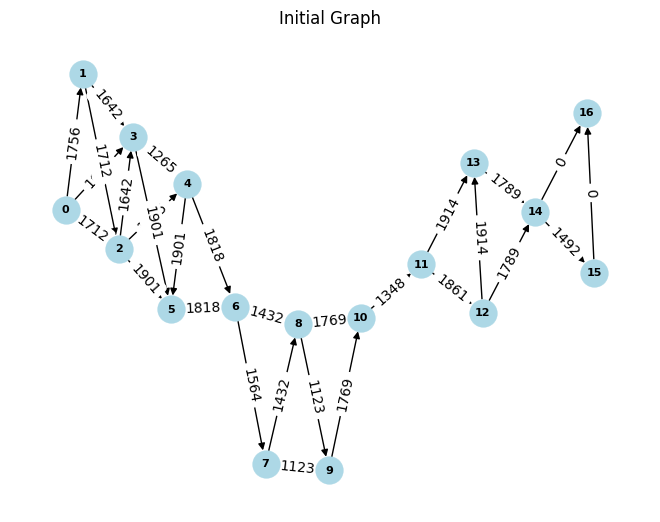

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import mip

# Create the initial graph
G = nx.DiGraph()

# Adding main path nodes
N=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] #new nodes: start, POI and end.
G.add_nodes_from(N)

# Define the arcs of the new graph as the possible distance between recharges:
# its contraints: 1) i<j: implies the direction of PART 1 s--> t
#                 2) implies the arc would only exist if the involved consumption is smaller than the limit delta.
A=[(i,j) for i in N for j in N if i<j and (sum(consumption[h] for h in range(i,j)) + sum(consumption_deviation[h] for h in range(i,j)) + sum(consumption_deviation[h] for h in range(i+1, j+1))  )<= delta ]

# Add the arcs to the graph
G.add_edges_from(A)

# Dictionaries of the cost of the edge(i,j)
cost_edges = { (i,j): inst_cost[j] for (i,j) in A}

# Show the valid arcs and their weight
for (i, j), cost in cost_edges.items():
    print('The arc: ' + str((i,j)) + ' has weight ' + str(cost_edges.get((i,j))))
    G.add_edge(i, j, weight=cost)

# Draw the initial graph
draw_graph(G, title="Initial Graph of Problem 2")

In [ ]:
import mip
# Create model
m= mip.Model()

# define the variable
f= {(i,j):m.add_var(var_type=mip.BINARY) for (i, j) in A}

#  define the contraints
# define b[i] for all i
b={i: 0 for i in N}
b[0]=1
b[16]=-1

# Write flow conservation constraint
for i in N:
  m.add_constr(mip.xsum(f[i,j] for j in N if (i,j) in A) - mip.xsum(f[j,i] for j in N if (j,i) in A)==b[i])

# minimize cost of installation
m.objective= mip.minimize(mip.xsum(inst_cost[j]*f[i,j] for (i,j) in A))

m.optimize()

<OptimizationStatus.OPTIMAL: 0>

In [ ]:
# Output the result
print("Total cost of installation:", m.objective_value)

Total cost of installation: 12924.0


In [ ]:
# I THINK WE CAN ERRASE THIS
#ALTERNATIVE (by cris) IN CASE THE ORDER OF THE NODES IS THE SAME AS IN PART 1
# IDEA:( mip.xsum(consumption[h] from i to j-1)  + mip.xsum(consumption_deviation[h] form i+1 to j) + mip.xsum(consumption_deviation[h] from i to j-1)  )<= delta
# IMPLEMENTATION:
  # A=[(j,i) for i in N for j in N if i<j and (sum(consumption[h] for h in range(i,j)) + sum(consumption_deviation[h] for h in range(i+1,j+1)) + sum(consumption_deviation[h] for h in range(i, j))  )<= delta ]
  #PRECAUTIONS, HERE I DEFINED ARCS AS j-->i (to consider always j as the big index)

In [ ]:
# Arcs of the minimun cost path
for (i,j) in A:
  if f[i,j].x >= 0.5:
    print(i,"--->", j)


0 ---> 3
3 ---> 4
4 ---> 6
6 ---> 8
8 ---> 10
10 ---> 11
11 ---> 12
12 ---> 14
14 ---> 16


### Drawn the final graph with the selected POI

***Expressing results form part 2 with numeration from part 1:*** ***(To allow comparisons)***

In [ ]:
#Print with part 1 numeration:
print("Considering numeration from part 1 for the nodes")
for (i,j) in A:
  if f[i,j].x >= 0.5:
    print(16-i,"--->", 16-j)


Considering numeration from part 1 for the nodes
16 ---> 13
13 ---> 12
12 ---> 10
10 ---> 8
8 ---> 6
6 ---> 5
5 ---> 4
4 ---> 2
2 ---> 0


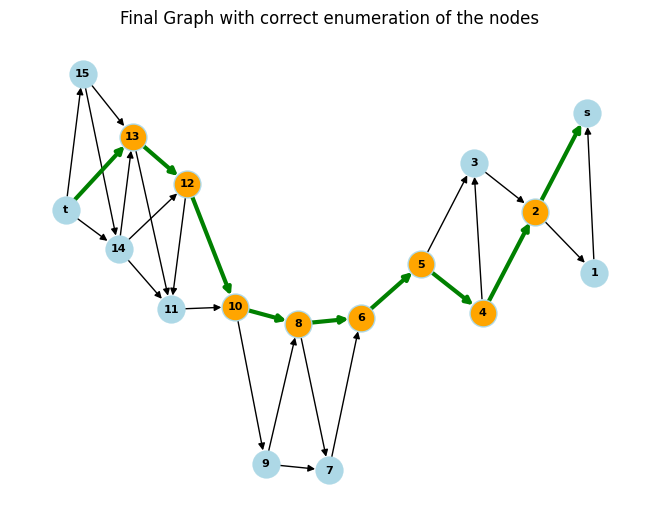

In [ ]:
selected_pois = [j for (i,j) in A if f[i,j].x > 0.001 and j!=16]
selected_arcs = [(i,j) for (i,j) in A if f[i,j].x > 0.001]
node_labels = {i: (16-i) for i in range(1, 16)}
node_labels[0] = 't'
node_labels[16] = 's'

draw_graph(G, selected_pois, selected_arcs, title="Final Graph with correct enumeration of the nodes", layout='spring', show_weight=False, node_labels=node_labels)

## Comment

Do you obtain the same solution? Why?

Asuming nodes were flipped:
- Objective function values are different
- Optimal locations are different:
  -   PROBLEM 1: $s-> 2 -> 4 -> 5 -> 7 -> 8 -> 10 -> 12 -> 14 -> t$
  -   PROBLEM 2: $t -> 13 -> 12 -> 10 -> 8 -> 6 -> 5 -> 4 -> 2 -> s$
  -   Differences:
          -  site 7 (problem 1) vs site 6 (problem 2)
          -  site 14 (problem 1) vs  site 13 (problem 2)

Different selection of nodes implies different choice of arcs. The differences are:

  - PROBLEM 1: $(14, t),  (12,14),  (7,8),  (5,7)$
  
  - PROBLEM 2: $(t, 13), (13,14), (6,8), (5,6)$

Explanation for difference in nodes $13$ and $14$:

 * cost_13 < cost_14  as $(1642) < (1712)$

 > In the PROBLEM 1:  one arc $(13,t)$ or arc $(12,13)$ should be unfeasible, otherwise it would have been chosen.
 > In the last section of part PROBLEM 1 the unfeasibility of ARC $(13, t)$ was proved. This leads to the choice of node $14$ despite having larger cost.

Explanation for difference in nodes 6 and 7:

 * cost_6 > ocst_7 as $(1769) > (1123)$ :

 > In the PROBLEM 1 arc $(7,5)$ or arc $(8,7)$ should be unfeasible, otherwise it would have been chosen.
 > In the section below this comment the unfeasibility of arc $(7,5)$ for part 2 was proved. This leads to the choice of node $6$ despite having larger cost.










In [ ]:
# check arc (7,5) pt 2
print(sum(consumption[h] for h in range(16-7,16-5)))
print(sum(consumption_deviation[h] for h in range(16-14,16-12)))
print(sum(consumption_deviation[h] for h in range(16-14+1,16-12+1)))
print('-----------------------------------------')
print('46 + 3,2 + 1.4 = 50.6 >50 UNFEASIBLE')

46
3.2
1.4000000000000001
-----------------------------------------
46 + 3,2 + 1.4 = 50.6 >50 UNFEASIBLE


In [ ]:
# check arc (8,7) pt 2
print(sum(consumption[h] for h in range(16-8,16-7)))
print(sum(consumption_deviation[h] for h in range(16-8,16-7)))
print(sum(consumption_deviation[h] for h in range(16-8 +1 ,16-7+1)))
print('-----------------------------------------')
print('9 + 0,9 + 2.1 = 12< 50 FEASIBLE')

9
0.9
2.1
-----------------------------------------
9 + 0,9 + 2.1 = 12< 50 FEASIBLE


### Testing the result obtained in the problem 1:
We consider a vector of 15 elements with binary value as the vector of POIs. The index $i$ of the vector is $1$ (permutation[i] == 1) if the POI of location $i'$ has a charging station installed, otherwise it is $0$. Then we generate all permutations of the possible charging stations installed in the POIs. After generating them, we take only the valid one (valid means that the battery consumption between two charging stations must be less than $50 Wh$).
Then we calculate the installation cost of each valid permutation and the one with the minimum installation cost is the optimal solution.


In [ ]:
import itertools

# Data
n1 = 15  # number of touristic sites
delta = 50  # max distance before recharge
consumption = [20, 32, 11, 37, 7, 14, 22, 5, 35, 17, 23, 3, 26, 24]  # consumption in Wh between consecutive locations
consumption_deviation = [1.1, 0.7, 0.4, 0.9, 2.1, 1.8, 0.5, 0.4, 1.6, 2.5, 1.4, 0.8, 2.0, 1.3, 0.1,0]  # consumption in Wh of the deviation
inst_cost = [1492, 1789, 1914, 1861, 1348, 1769, 1123, 1432, 1564, 1818, 1901, 1265, 1642, 1712, 1756]  # installation cost in euro

# Generate all possible permutations of binary values in a vector of 15 elements
permutations = tuple(itertools.product([0, 1], repeat=n1))

min_cost = float('inf')
min_cost_permutation = None

# Extract only the valid permutations along with their total installation cost
valid_permutations_with_cost = []
print("All the valid permutation of installed charging point")
for perm in permutations:
    if is_valid_permutation(perm):
        cost = total_installation_cost(perm)
        valid_permutations_with_cost.append((perm, cost))
        if cost < min_cost:
            min_cost = cost
            min_cost_permutation = perm
                                                                                           #    \
#Print the valid permutations along with their total installation cost                     #     |
print("Total number of valid permutations:", len(valid_permutations_with_cost))            #     |----------> comment this block to print only the optimal solution
for i, (perm, cost) in enumerate(valid_permutations_with_cost, 1):                         #     |
   print("Valid Permutation", i, ":", perm, "Total Installation Cost:", cost, "euros")     #     |
                                                                                           #    /
# Print the minimum installation cost and the corresponding permutation
print("Minimum Installation Cost:", min_cost, "euros")
print("Permutation with Minimum Installation Cost:", min_cost_permutation)


All the valid permutation of installed charging point
(0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0)
(0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1)
(0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0)
(0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1)
(0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0)
(0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1)
(0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0)
(0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1)
(0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0)
(0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1)
(0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0)
(0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1)
(0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0)
(0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1)
(0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0)
(0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1)
(0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0)
(0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1)
(0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0)
(0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1)
(0, 1, 0, 1, 1, 0, 1, 1, 1


###Testing the result obtained in the problem 2:

In [ ]:
import itertools

# Data
n = 15  # number of nodes on the main course
n1 = 15 #number of touristic sites
consumption = [12, 24, 7, 8, 35, 21, 19, 9, 31, 15, 21, 6, 23, 29] # consumption (in Wh) between two consecutive location along the main course
consumption_deviation = [1.7, 2.1, 1.1, 0.3, 0.4, 2.3, 0.2, 0.9, 2.1, 4.3, 5.2, 0.1, 2.8, 0.9, 0.1] # consumption (in Wh) of the deviation

# to compute the installation cost you have to bring the vector from the PROBLEM 1 and reverse it
inst_cost = [1492, 1789, 1914, 1861, 1348, 1769, 1123, 1432, 1564, 1818, 1901, 1265, 1642, 1712, 1756]
inst_cost.reverse() # reverse() := swap the last element with the first element, the second last element with the second element, and so on.



# Generate all possible permutations of binary values in a vector of 15 elements
permutations = tuple(itertools.product([0, 1], repeat=n1))


min_cost = float('inf')
min_cost_permutation = None

# Extract only the valid permutations along with their total installation cost
valid_permutations_with_cost = []
print("All the valid permutation of installed charging point")
for perm in permutations:
    if is_valid_permutation(perm):
        cost = total_installation_cost(perm)
        valid_permutations_with_cost.append((perm, cost))
        if cost < min_cost:
            min_cost = cost
            min_cost_permutation = perm

                                                                                           #    \
#Print the valid permutations along with their total installation cost                     #     |
print("Total number of valid permutations:", len(valid_permutations_with_cost))            #     |----------> comment this block to print only the optimal solution
for i, (perm, cost) in enumerate(valid_permutations_with_cost, 1):                         #     |
   print("Valid Permutation", i, ":", perm, "Total Installation Cost:", cost, "euros")     #     |
                                                                                           #    /

# Print the minimum installation cost and the corresponding permutation
print("Minimum Installation Cost:", min_cost, "euros")
print("Permutation with Minimum Installation Cost:", min_cost_permutation)


All the valid permutation of installed charging point
Total number of valid permutations: 540
Valid Permutation 1 : (0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0) Total Installation Cost: 13613 euros
Valid Permutation 2 : (0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1) Total Installation Cost: 15105 euros
Valid Permutation 3 : (0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0) Total Installation Cost: 13560 euros
Valid Permutation 4 : (0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1) Total Installation Cost: 15052 euros
Valid Permutation 5 : (0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0) Total Installation Cost: 15474 euros
Valid Permutation 6 : (0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1) Total Installation Cost: 16966 euros
Valid Permutation 7 : (0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0) Total Installation Cost: 14736 euros
Valid Permutation 8 : (0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1) Total Installation Cost: 16228 euros
Valid Permutation 9 : (0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0